# **Final Project - Applied Mathematics**
# The following notebook is the code for simulation.

The Agent class is defined as follow:

In [3]:
class Agent:
    def __init__(self, infected, immune, remaining_days_of_infection, remaining_days_of_immunity):
        self.infected = infected
        self.immune = immune
        self.remaining_days_of_infection = remaining_days_of_infection
        self.remaining_days_of_immunity = remaining_days_of_immunity
        self.susceptible=True

The following function for picking two rando agents.

In [4]:
import random
def PickTwoAgentsWithContacts(numAgents):
    """
    Randomly selects two different agent indices from the range [0, numAgents-1]
    with a probability of being in contact.

    Parameters:
    - numAgents (int): The total number of agents.
    - contact_prob (float): The probability of two agents being in contact.

    Returns:
    - tuple: A tuple containing two distinct agent indices.
    """
    # Randomly select two initial indices
    index1 = random.randint(0, numAgents - 1)
    index2 = random.randint(0, numAgents - 1)

    # Ensure the selected indices are different
    while index1 == index2 :
        index1 = random.randint(0, numAgents - 1)
        index2 = random.randint(0, numAgents - 1)

    return index1, index2

The following function for initilaizing the agents array

In [5]:
import random

def start_step(agents,number_of_agents,infected_at_start,immunity_duartion,infection_duration):
  if infected_at_start  > number_of_agents:
            raise ValueError("Number of initially infected agents cannot exceed the total number of agents.")
 ## create agents
  for i in range(0,number_of_agents):
    agents.append(Agent(False,False,immunity_duartion,infection_duration))
  ## infect random subset at the start
  infected_indices = random.sample(range(number_of_agents), infected_at_start)
  for index in infected_indices:
        agents[index].infected = True
        agents[index].remaining_days_of_infection = infection_duration
        agents[index].susceptible=False
  return agents

The following code for infecting agent

In [6]:
import random

def infect(agent1,agent2,infection_probability,infection_duration):
    random_number = random.random()
    # If agent1 is not infected
    if not agent1.infected and agent2.infected and not agent1.immune and random_number < infection_probability:
        agent1.infected = True
        agent1.remaining_days_of_infection = infection_duration
        #overall_infected += 1
        ##susceptibles-=1
        agent1.susceptible=False
    # If agent2 is not infected
    elif not agent2.infected and agent1.infected and not agent2.immune and random_number < infection_probability:
        agent2.infected = True
        agent2.remaining_days_of_infection = infection_duration
        #overall_infected += 1
        agent2.susceptible=False

        ##susceptibles-=1
    return agent1, agent2

The following code for death and birth

In [7]:
import numpy as np

def Birth_death(agents, birth_pulse, birth_rate_yearly, infected_per_birth_duration, birth_interval, birth_duration, immunity_duration, infection_duration, new_born, deads,N):
    num_new_agents = 0
    num_dead_agents = 0
    b = 0.1
    m=(birth_rate_yearly-b)/int(N)



    # Check if the birth pulse matches the birth interval
    if birth_pulse % birth_interval < birth_duration:
        # Calculate the expected number of new agents over the birth duration
        expected_new_agents_over_duration = birth_rate_yearly * len(agents)

        # Generate the number of new agents using Poisson distribution
        num_new_agents = np.random.poisson(expected_new_agents_over_duration/birth_duration)

        # Create new agents with the specified parameters
        agents = create_new_agents(agents, num_new_agents, infected_per_birth_duration, immunity_duration, infection_duration)


    # Calculate daily death rate
    death_rate = m * len(agents) + b
    #daily_death_rate = 1 - pow((1 - death_rate), 1 / birth_interval)
    daily_death_rate=death_rate/birth_interval
    #print(daily_death_rate)

    # Generate the number of dead agents using binomial distribution
    num_dead_agents = np.random.binomial(len(agents), daily_death_rate)

    # Remove dead agents
    agents = remove_dead_agents(agents, num_dead_agents)

    return agents, num_dead_agents,num_new_agents

The following code for revmoving dead agents

In [8]:
def remove_dead_agents(agents, num_dead_agents):
    global NumberOfInfected
    if num_dead_agents >= len(agents):
        agents.clear()
    else:
        for _ in range(num_dead_agents):
            index = random.randint(0, len(agents) - 1)
            agents.pop(index)
    return agents

The following code for creating new agents with specifec number of infected agents

In [9]:
def create_new_agents(agents, num_new_agents,infected_per_birth_duration, immunity_duration, infection_duration):
    number=0
    if infected_per_birth_duration > len(agents):
        number = len(agents)
    else :
      number=infected_per_birth_duration

    for i in range(num_new_agents):
        if i < number:
            agents.append(Agent(True, False, immunity_duration, infection_duration))

        else:
            agents.append(Agent(False, False, immunity_duration, infection_duration))

    return agents

The following code is for updating the parameters after each simulation step

In [10]:
def update_params(agents, immunity_duration,Overall_infected,susceptibles):
    for i in range(len(agents)):
        if agents[i].infected:
            # If the agent is infected
            agents[i].remaining_days_of_infection -= 1

            if agents[i].remaining_days_of_infection == 0:
                # The agent has ended the duration of infection and started the immunity duration
                agents[i].infected = False
                agents[i].immune = True
                agents[i].remaining_days_of_immunity = immunity_duration
                #Overall_infected -= 1

        else:
            if agents[i].immune:
                # The agent is immune
                agents[i].remaining_days_of_immunity -= 1

                if agents[i].remaining_days_of_immunity == 0:
                    # The agent has ended the immunity duration
                    agents[i].immune = False
                   # susceptibles+=1
                    agents[i].susceptible=True
    Overall_infected=sum(agent.infected == True for agent in agents)

    susceptibles=sum(agent.susceptible == True for agent in agents)
    return agents,Overall_infected,susceptibles

The following code is the main simulation

In [24]:
import os
import pandas as pd
import matplotlib.pyplot as plt
def simulation_run(infection_duration,immunity_duration,number_of_agents,simualtion_duration,birth_rate_yearly,birth_duration,infected_at_start,R0_,N_):
  ##parameters
  infection_duration=infection_duration
  immunity_duration=immunity_duration
  number_of_agents=number_of_agents
  simualtion_duration= simualtion_duration
  birth_rate_yearly=birth_rate_yearly
  birth_interval=365
  birth_duration=birth_duration
  infected_at_start=infected_at_start
  new_born=[0]* int(simualtion_duration)
  infected=[0]* int(simualtion_duration)
  deads=[0]* int(simualtion_duration)
  birth_pulse=0
  susceptibles= [0]* int(simualtion_duration)
  sus=0
  infected=0
  num_new_birhths=0
  overALL_infected=[0]* int(simualtion_duration)
  ##
  infected_per_birth_duration=0
  number_of_interactions_per_day_per_agent=1/10
  R0=R0_
  TMP=infection_duration*number_of_interactions_per_day_per_agent
  infection_probability=float(R0)/TMP
  N=N_
  overall_infected=0
  ##

  agents=[]
  agents=start_step(agents,number_of_agents,infected_at_start,immunity_duration,infection_duration)
  overALL_infected[0]=(infected_at_start)
  susceptibles.append(len(agents)-infected_at_start)
  number_of_interactions_per_day = int(len(agents) *number_of_interactions_per_day_per_agent // 2)



  for i in range(simualtion_duration):
    for j in range(number_of_interactions_per_day):
      index1, index2 = PickTwoAgentsWithContacts(len(agents))
      agent1, agent2=infect(agents[index1],agents[index2],infection_probability,infection_duration)
    birth_pulse += 1
    agents, num_dead_agents,num_new_birhths=Birth_death(agents,birth_pulse,birth_rate_yearly,infected_per_birth_duration,birth_interval,birth_duration,immunity_duration,infection_duration,new_born,deads,N)
    deads[i]=(num_dead_agents)
    new_born[i]=num_new_birhths
    agents,infected,sus=update_params(agents, immunity_duration,infected,sus)
    susceptibles[i]=(sus)
    overALL_infected[i]=(infected)

  return overALL_infected,susceptibles,new_born,deads



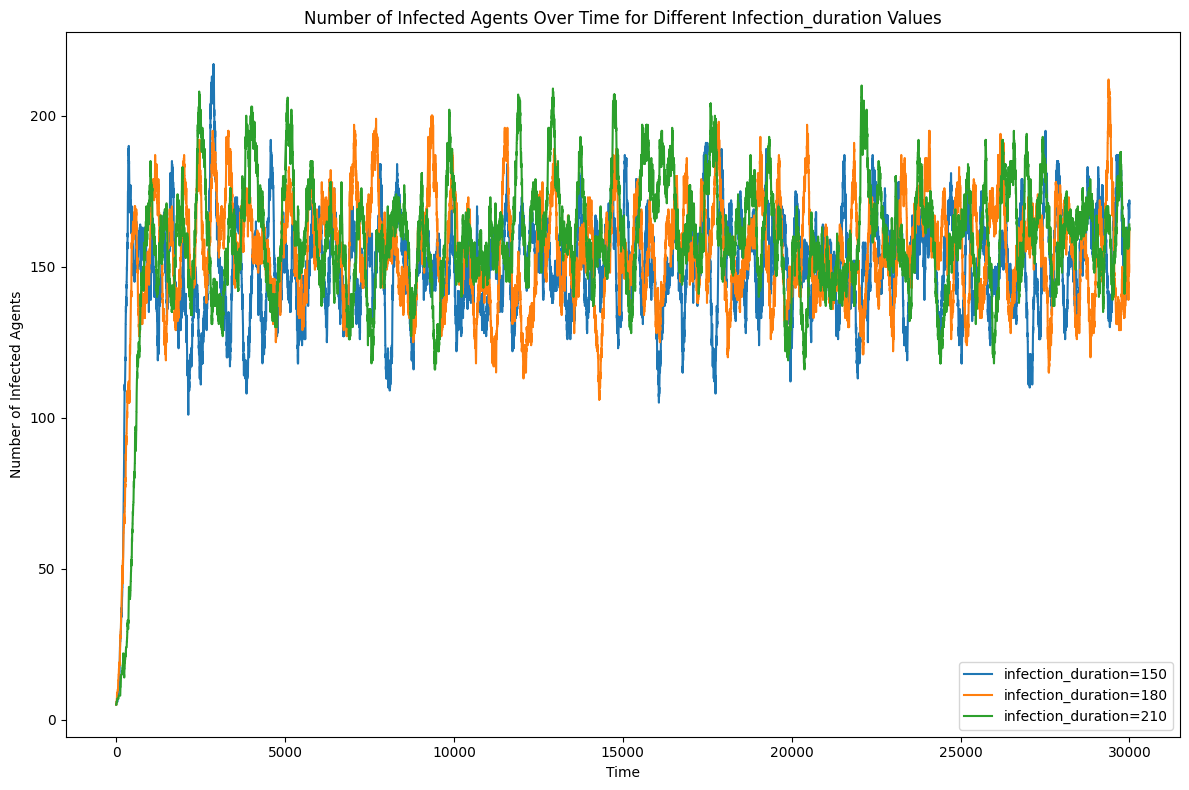

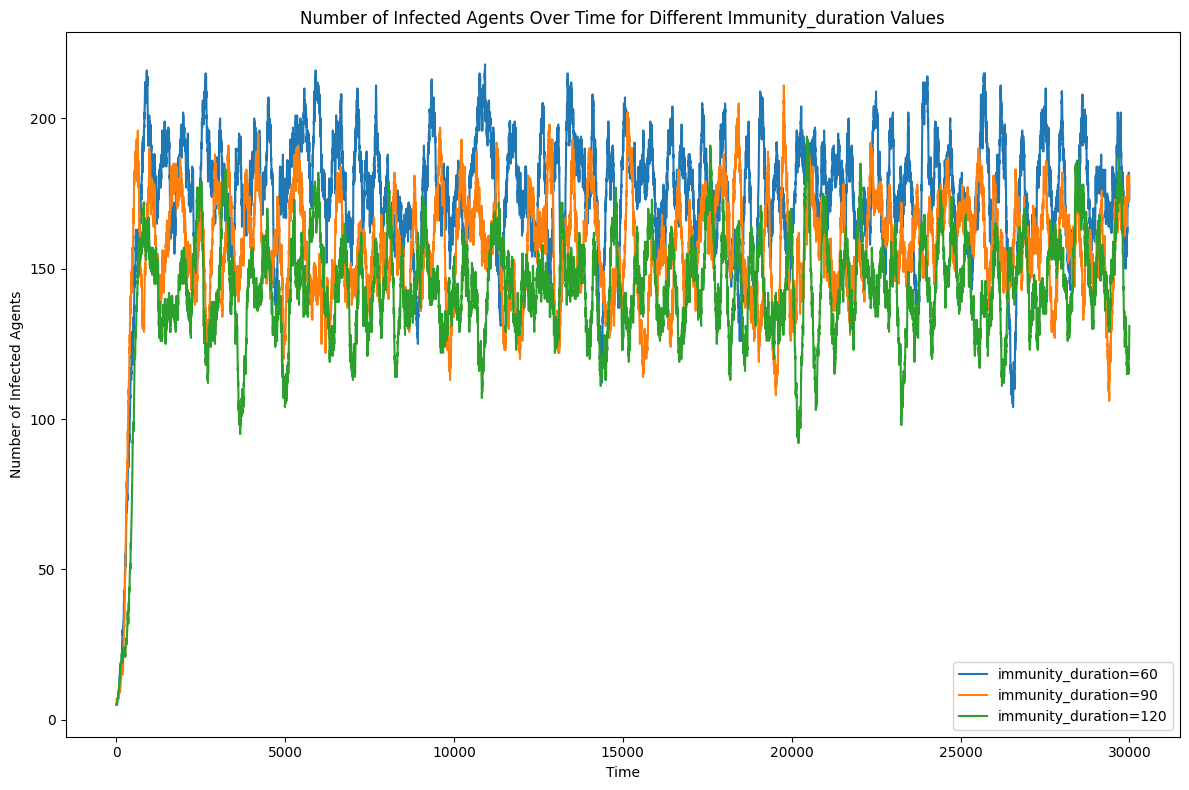

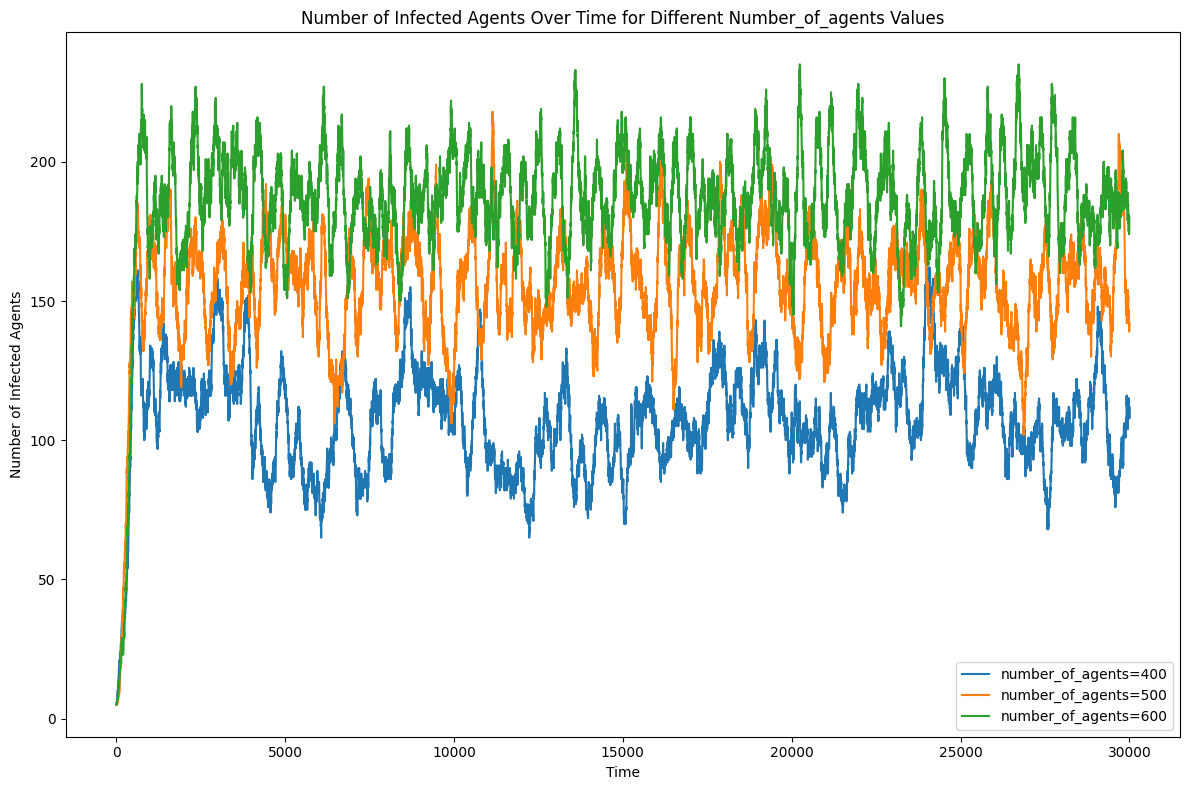

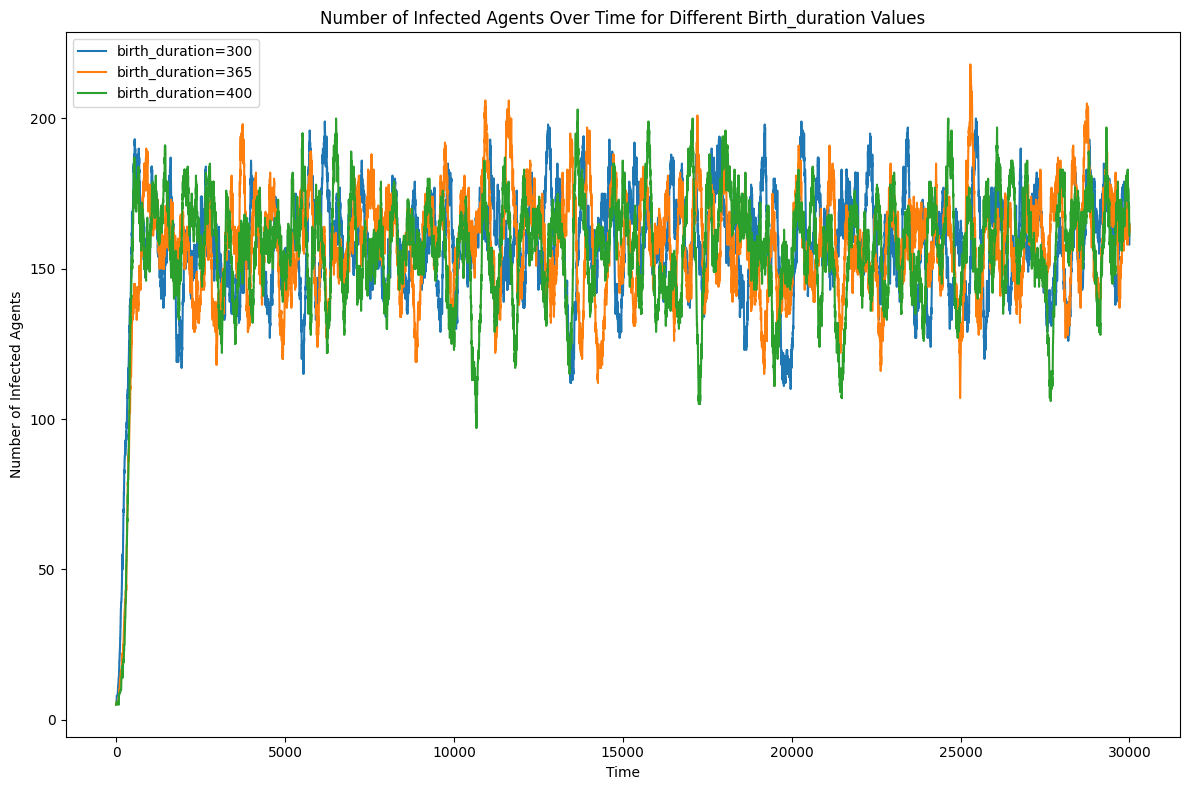

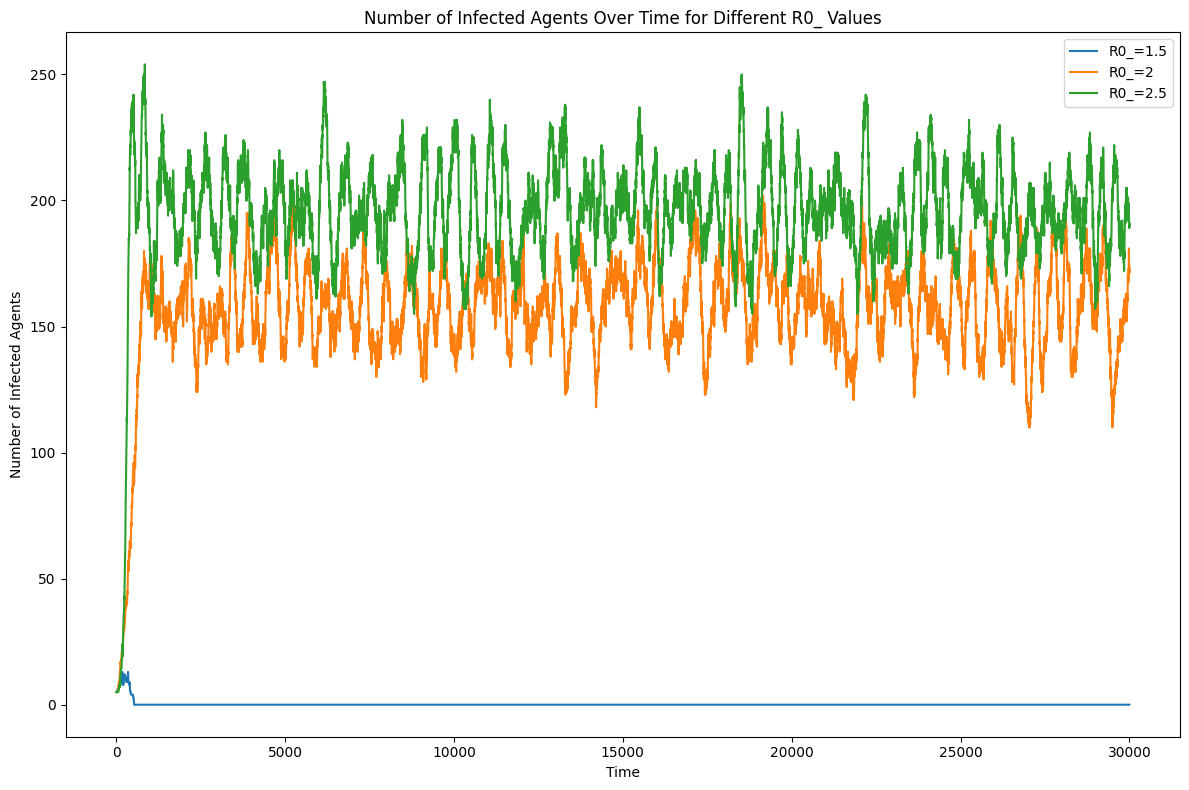

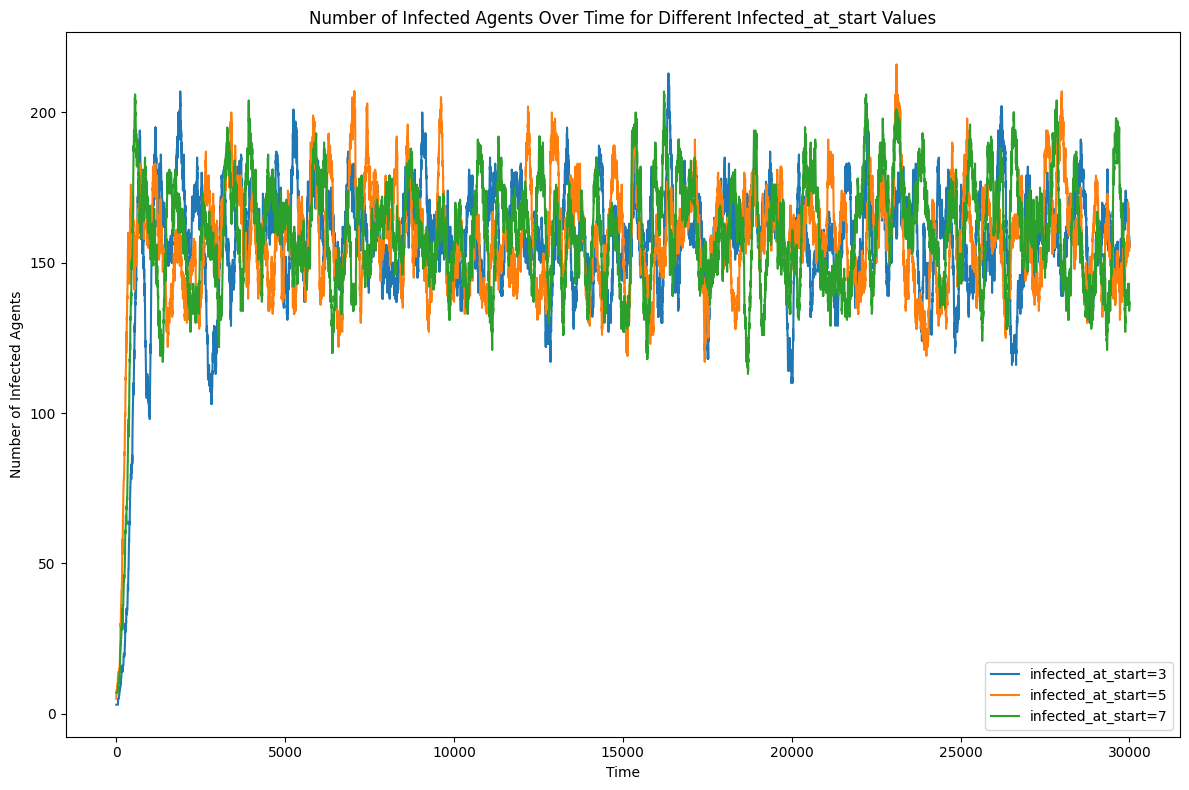

In [25]:
def run_simulations_for_multiple_parameters(param_values, param_name, fixed_params):
    results = {}
    for value in param_values:
        params = fixed_params.copy()
        params[param_name] = value
        overALL_infected, susceptibles, new_born, deads = simulation_run(**params)
        results[value] = overALL_infected
    return results

def plot_results(results, param_name):
    plt.figure(figsize=(12, 8))
    for value, infected in results.items():
        plt.plot(infected, label=f'{param_name}={value}')
    plt.xlabel('Time')
    plt.ylabel('Number of Infected Agents')
    plt.title(f'Number of Infected Agents Over Time for Different {param_name.capitalize()} Values')
    plt.legend()
    plt.tight_layout()
    plt.savefig(f'infected_agents_multiple_{param_name}.pdf')
    plt.show()

# Fixed parameters
fixed_params = {
    'infection_duration': 180,
    'immunity_duration': 90,
    'number_of_agents': 500,
    'simualtion_duration': 30000,
    'birth_rate_yearly': 0.3,

    'birth_duration': 365,
    'infected_at_start': 5,
    'R0_': 2,
    'N_': 500
}



# Different values for each parameter
param_values_dict = {
    'infection_duration': [150, 180, 210],
    'immunity_duration': [60, 90, 120],
    'number_of_agents': [400, 500, 600],
    'birth_duration': [300, 365, 400],
    'R0_': [1.5, 2, 2.5],

    'infected_at_start': [3, 5, 7]
}

# Run simulations and plot results for each parameter
for param_name, param_values in param_values_dict.items():
    results = run_simulations_for_multiple_parameters(param_values, param_name, fixed_params)
    plot_results(results, param_name)